# Lab 1: Subset Selection Methods

## Best Subset Selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
hitters = pd.read_csv('../../data/Hitters.csv', index_col=0, na_values='NA').dropna()
hitters = pd.get_dummies(hitters, drop_first=True)
print(hitters.shape)
print(hitters.isnull().sum())

(263, 20)
AtBat          0
Hits           0
HmRun          0
Runs           0
RBI            0
Walks          0
Years          0
CAtBat         0
CHits          0
CHmRun         0
CRuns          0
CRBI           0
CWalks         0
PutOuts        0
Assists        0
Errors         0
Salary         0
League_N       0
Division_W     0
NewLeague_N    0
dtype: int64


In [3]:
import itertools
import statsmodels.api as sm
import time

def processSubset(feature_set):
    model = sm.OLS(y, X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {'model': regr, 'RSS': RSS}

def getBest(k):
    tic = time.time()
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
        
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print('Processed {} models on {} predictors in {} seconds' \
         .format(models.shape[0], k, toc-tic))
    
    return best_model

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
X = hitters[hitters.columns.drop('Salary')]
y = hitters['Salary']

bss_models = pd.DataFrame(columns=['RSS', 'model'])

#n = 8 #This takes about 5 minutes on my computer
n = 20 #This takes about 15 minutes on my computer

tic = time.time()
for i in range(1, n):
    bss_models.loc[i] = getBest(i)
    
toc = time.time()
print('Total elapsed time: {} seconds'.format(toc-tic))

Processed 19 models on 1 predictors in 0.04100227355957031 seconds
Processed 171 models on 2 predictors in 0.23801350593566895 seconds
Processed 969 models on 3 predictors in 1.4160809516906738 seconds
Processed 3876 models on 4 predictors in 5.684325218200684 seconds
Processed 11628 models on 5 predictors in 17.600006580352783 seconds
Processed 27132 models on 6 predictors in 42.40542531013489 seconds
Processed 50388 models on 7 predictors in 80.98663210868835 seconds
Processed 75582 models on 8 predictors in 125.35316967964172 seconds
Processed 92378 models on 9 predictors in 157.44600558280945 seconds
Processed 92378 models on 10 predictors in 160.36617255210876 seconds
Processed 75582 models on 11 predictors in 140.74605011940002 seconds
Processed 50388 models on 12 predictors in 99.10566878318787 seconds
Processed 27132 models on 13 predictors in 55.27816152572632 seconds
Processed 11628 models on 14 predictors in 23.76435899734497 seconds
Processed 3876 models on 15 predictors in

In [6]:
for i in bss_models.index:
    print('Best {} variables model: RSS: {:e}'.format(i, bss_models.loc[i]['RSS']))
    print('{}\n'.format(bss_models.loc[i]['model'].summary().tables[1]))

Best 1 variables model: RSS: 4.321393e+07
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Hits           4.8833      0.214     22.787      0.000       4.461       5.305

Best 2 variables model: RSS: 3.073305e+07
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Hits           2.9538      0.261     11.335      0.000       2.441       3.467
CRBI           0.6788      0.066     10.295      0.000       0.549       0.809

Best 3 variables model: RSS: 2.941071e+07
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Hits           3.4057      0.288     11.842      0.000       2.839       3.972
CRBI           0.6964      0.065     10.742      0.000       0.569       0.824
Div

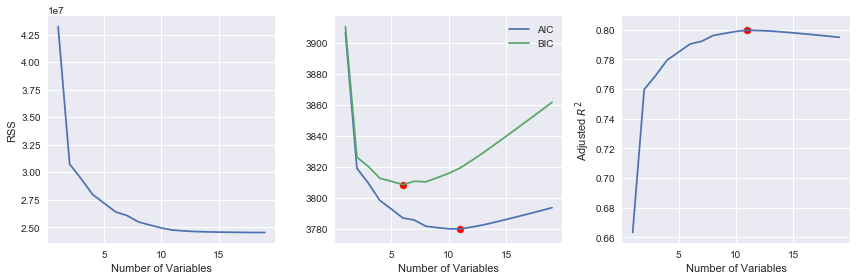

In [9]:
aic = []
bic = []
adj_r2 = []

for i in bss_models.index:
    aic.append(bss_models.loc[i]['model'].aic)
    bic.append(bss_models.loc[i]['model'].bic)
    adj_r2.append(bss_models.loc[i]['model'].rsquared_adj)
    
aic = np.array(aic)
bic = np.array(bic)
adj_r2 = np.array(adj_r2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    
ax1.plot(bss_models.index, bss_models['RSS'])
ax1.set(xlabel='Number of Variables', ylabel='RSS')

ax2.plot(bss_models.index, aic)
ax2.plot(bss_models.index, bic)
ax2.legend(['AIC', 'BIC'])
ax2.set(xlabel='Number of Variables')
ax2.scatter(aic.argmin()+1, aic[aic.argmin()], c='r')
ax2.scatter(bic.argmin()+1, bic[bic.argmin()], c='r')

ax3.plot(bss_models.index, adj_r2)
ax3.set(xlabel='Number of Variables', ylabel=r'Adjusted $R^2$')
ax3.scatter(adj_r2.argmax()+1, adj_r2[adj_r2.argmax()], c='r')

fig.tight_layout()

## Forward and Backward Stepwise Selection

In [22]:
#forward selection

unused_vars = X.columns
model_vars = []
fs_models = {}

for i in range(len(unused_vars)):
    #reset the minimum RSS each time
    min_rss = 1e100
    #loop through the available variables
    for v in unused_vars:
        #fit the model with the previous variables plus the new variable
        lr = sm.OLS(y, X[model_vars + [v]]).fit()
        #calculate the rss for the model
        rss = ((lr.predict(X[model_vars + [v]]) - y) ** 2).sum()
        #find which model has the lowest RSS
        if rss < min_rss:
            min_rss = rss
            min_var = v
    #add the variable that resulted in the lowest RSS to model_vars (used)
    model_vars.append(min_var)
    #delete the variable that resulted in the lowest RSS from unused_vars
    unused_vars = unused_vars.drop(min_var)
    #add the variables, fitted model, and RSS to a dictionary for easy lookup
    fs_models[i+1] = [list(model_vars), sm.OLS(y, X[model_vars]).fit(), min_rss]

In [23]:
#backward selection
model_vars = X.columns
omitted_vars = []
bs_models = {}

for i in range(len(model_vars), 0, -1):
    rss = ((sm.OLS(y, X[model_vars]).fit().predict(X[model_vars]) - y) ** 2).sum()
    bs_models[i] = [list(model_vars), sm.OLS(y, X[model_vars]).fit(), rss]
    min_rss = 1e100
    if len(model_vars) > 1:
        for v in model_vars:
            lr = sm.OLS(y, X[model_vars.drop(v)]).fit()
            rss = ((lr.predict(X[model_vars.drop(v)]) - y) ** 2).sum()
            if rss < min_rss:
                min_rss = rss
                min_var = v
        model_vars = model_vars.drop(v)

In [49]:
ind = 7

print('{} Variables\n-----------'.format(ind))
print('Best subset selection\n\tVariables: {}\n\tRSS: {}\n' \
      .format(list(bss_models.loc[ind]['model'].params.index), 
              bss_models.loc[ind]['RSS']))
print('Forward selection\n\tVariables: {}\n\tRSS: {}\n' \
      .format(fs_models[ind][0], fs_models[ind][2]))
print('Backward selection\n\tVariables: {}\n\tRSS: {}\n' \
      .format(bs_models[ind][0], bs_models[ind][2]))

7 Variables
-----------
Best subset selection
	Variables: ['Hits', 'Walks', 'CAtBat', 'CHits', 'CHmRun', 'PutOuts', 'Division_W']
	RSS: 26064130.610340584

Forward selection
	Variables: ['Hits', 'CRBI', 'Division_W', 'PutOuts', 'AtBat', 'Walks', 'League_N']
	RSS: 26212278.82362643

Backward selection
	Variables: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years']
	RSS: 31747831.740722436



## Choosing Among Models Using the Validation Set Approach and Cross-Validation

In [87]:
lr1 = sm.OLS(y, sm.add_constant(X)).fit()
y_pred1 = lr1.predict(sm.add_constant(X))
print(((y_pred1 - y)**2).mean())

lr2 = LinearRegression()
lr2.fit(X, y)
y_pred2 = lr2.predict(X)
print(((y_pred2 - y)**2).mean())

92017.86901772924
92017.86901772917


In [82]:
lr1.params

AtBat          -1.597454
Hits            7.033003
HmRun           4.121030
Runs           -2.377622
RBI            -1.087339
Walks           6.155957
Years           9.519555
CAtBat         -0.201828
CHits           0.138001
CHmRun         -0.166934
CRuns           1.506992
CRBI            0.774167
CWalks         -0.785064
PutOuts         0.285626
Assists         0.313743
Errors         -2.046266
League_N       86.813853
Division_W    -97.516017
NewLeague_N   -23.913331
dtype: float64

In [83]:
lr2.coef_

array([  -1.9798729 ,    7.50076754,    4.3308829 ,   -2.37620998,
         -1.04496196,    6.23128632,   -3.48905426,   -0.17134047,
          0.13399096,   -0.17286107,    1.45430494,    0.8077088 ,
         -0.81157091,    0.28189251,    0.37106921,   -3.36076048,
         62.59942304, -116.84924564,  -24.76232511])

In [85]:
import statsmodels.formula.api as smf
smf.ols('y ~ X', {'y': y, 'X': X}).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,163.1036,90.779,1.797,0.074,-15.710,341.917
X[0],-1.9799,0.634,-3.123,0.002,-3.229,-0.731
X[1],7.5008,2.378,3.155,0.002,2.818,12.184
X[2],4.3309,6.201,0.698,0.486,-7.885,16.546
X[3],-2.3762,2.981,-0.797,0.426,-8.248,3.495
X[4],-1.0450,2.601,-0.402,0.688,-6.168,4.078
X[5],6.2313,1.829,3.408,0.001,2.630,9.833
X[6],-3.4891,12.412,-0.281,0.779,-27.938,20.960
X[7],-0.1713,0.135,-1.267,0.206,-0.438,0.095
X[8],0.1340,0.675,0.199,0.843,-1.195,1.463
